# Proximal Policy Optimization (PPO)

Proximal Policy Optimization (PPO) is a **state-of-the-art policy gradient algorithm** in Reinforcement Learning that improves the stability of policy updates.

PPO modifies the standard policy gradient objective to **avoid large updates** that could collapse the policy:

$$
L^{CLIP}(\theta) = \mathbb{E}_t \Big[ \min \Big( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \Big) \Big]
$$

Where:

- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)}$ is the probability ratio  
- $\hat{A}_t$ is the advantage estimate at timestep $t$  
- $\epsilon$ is a hyperparameter controlling the clipping range  
- The $\min$ ensures that the objective does not increase too much, **preventing large destructive policy updates**.


## 1. Standard Policy Gradient

The standard REINFORCE objective:

$$
J(\theta) = \mathbb{E}_t \Big[ \log \pi_\theta(a_t|s_t) \hat{A}_t \Big]
$$

Gradient:

$$
\nabla_\theta J(\theta) = \mathbb{E}_t \Big[ \nabla_\theta \log \pi_\theta(a_t|s_t) \hat{A}_t \Big]
$$

---

## 2. PPO Clipped Objective

To prevent large policy updates:

$$
r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)}
$$

$$
L^{CLIP}(\theta) = \mathbb{E}_t \Big[ \min \big( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \big) \Big]
$$

- Ensures updates are **proximal** to old policy  
- $\epsilon$ (e.g., 0.2) controls allowable deviation  
- Prevents performance collapse in high-variance policy gradients


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Toy MNIST pixel sequence (length 10)
target_sequence = np.random.rand(10)

def reward_fn(action, target):
    """Reward: negative squared error"""
    return - (action - target)**2


We model a **simplified AR-LM policy**:

$$
a_t \sim \pi_\theta(a_t|s_t) = \mathcal{N}(\mu_\theta(s_t), \sigma^2)
$$

- $s_t$: previous pixels  
- $a_t$: next predicted pixel  
- $\mu_\theta(s_t)$: policy mean  

PPO update uses **clipped ratio**:

$$
r_t = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_\text{old}}(a_t|s_t)}
$$

$$
L^{CLIP} = \min(r_t \hat{A}_t, \text{clip}(r_t, 1-\epsilon, 1+\epsilon)\hat{A}_t)
$$


In [2]:
seq_len = len(target_sequence)
sigma = 0.2
epsilon = 0.2
eta = 0.05
mu_theta = np.zeros(seq_len)       # current policy mean
mu_old = mu_theta.copy()           # old policy mean
episodes = 50
reward_history = []

for ep in range(episodes):
    actions = np.random.normal(mu_theta, sigma)  # sample actions
    rewards = np.array([reward_fn(a, t) for a, t in zip(actions, target_sequence)])
    advantages = rewards - rewards.mean()       # simple advantage
    ratios = np.exp(-(actions - mu_theta)**2/(2*sigma**2)) / np.exp(-(actions - mu_old)**2/(2*sigma**2))

    clipped_ratios = np.clip(ratios, 1-epsilon, 1+epsilon)
    L_clip = np.minimum(ratios*advantages, clipped_ratios*advantages)

    # PPO policy update
    grad_log = (actions - mu_theta) / sigma**2
    mu_theta += eta * grad_log * L_clip

    # Store reward
    reward_history.append(rewards.sum())

    # Update old policy
    mu_old = mu_theta.copy()

    print(f"Episode {ep+1}: Cumulative Reward = {rewards.sum():.4f}")


Episode 1: Cumulative Reward = -4.5716
Episode 2: Cumulative Reward = -4.5093
Episode 3: Cumulative Reward = -4.0590
Episode 4: Cumulative Reward = -2.4220
Episode 5: Cumulative Reward = -2.2408
Episode 6: Cumulative Reward = -1.4857
Episode 7: Cumulative Reward = -1.2166
Episode 8: Cumulative Reward = -1.5419
Episode 9: Cumulative Reward = -1.3693
Episode 10: Cumulative Reward = -1.2756
Episode 11: Cumulative Reward = -1.2187
Episode 12: Cumulative Reward = -0.9868
Episode 13: Cumulative Reward = -0.8009
Episode 14: Cumulative Reward = -0.8213
Episode 15: Cumulative Reward = -0.2768
Episode 16: Cumulative Reward = -0.6047
Episode 17: Cumulative Reward = -0.4574
Episode 18: Cumulative Reward = -0.5749
Episode 19: Cumulative Reward = -0.7165
Episode 20: Cumulative Reward = -0.3928
Episode 21: Cumulative Reward = -0.6335
Episode 22: Cumulative Reward = -1.0986
Episode 23: Cumulative Reward = -0.8696
Episode 24: Cumulative Reward = -0.4803
Episode 25: Cumulative Reward = -0.7733
Episode 2

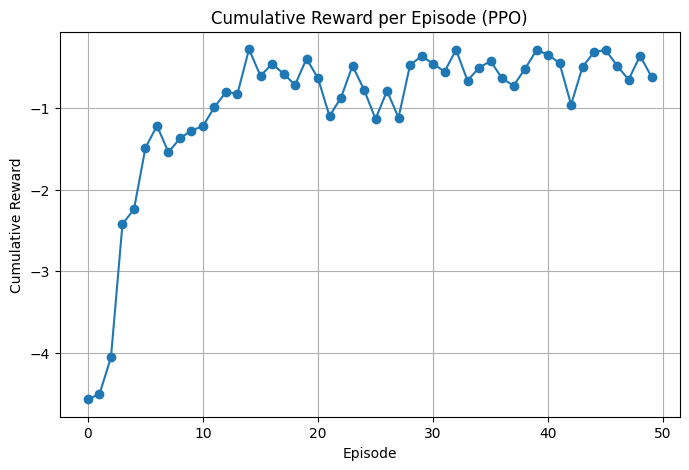

In [3]:
plt.figure(figsize=(8,5))
plt.plot(reward_history, marker='o')
plt.title("Cumulative Reward per Episode (PPO)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid()
plt.show()


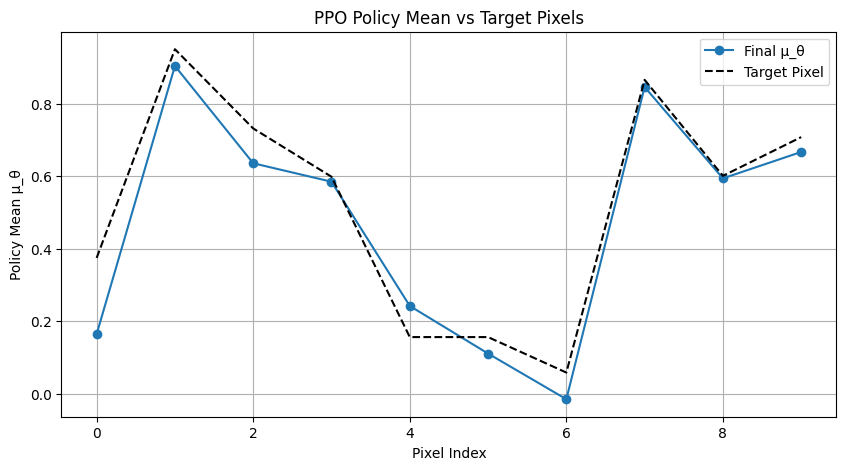

In [4]:
plt.figure(figsize=(10,5))
plt.plot(mu_theta, 'o-', label='Final μ_θ')
plt.plot(target_sequence, '--', color='black', label='Target Pixel')
plt.title("PPO Policy Mean vs Target Pixels")
plt.xlabel("Pixel Index")
plt.ylabel("Policy Mean μ_θ")
plt.legend()
plt.grid()
plt.show()


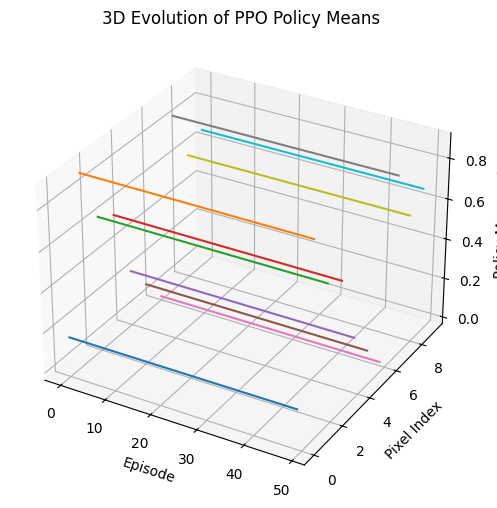

In [5]:
from mpl_toolkits.mplot3d import Axes3D

episodes_grid = np.arange(episodes)
pixels_grid = np.arange(seq_len)
mu_history = np.tile(mu_theta, (episodes, 1))  # simplified for visualization

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(seq_len):
    ax.plot(episodes_grid, [i]*episodes, mu_history[:,i])

ax.set_xlabel("Episode")
ax.set_ylabel("Pixel Index")
ax.set_zlabel("Policy Mean μ_θ")
ax.set_title("3D Evolution of PPO Policy Means")
plt.show()


## Interpretation

1. PPO keeps updates **proximal** to the old policy, stabilizing learning.
2. μ_θ gradually aligns with the target pixel intensities.
3. Cumulative rewards improve as policy learns to match the target sequence.

---

## Use Case in Generative AI

- PPO can fine-tune AR-LMs or image/pixel generators.
- Rewards can reflect human preference (RLHF) or sequence quality.
- More stable than vanilla policy gradient methods, preventing destructive updates.
